### Import dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
% pip install wandb

     |████████████████████████████████| 1.8MB 13.3MB/s 
     |████████████████████████████████| 133kB 62.0MB/s 
     |████████████████████████████████| 163kB 63.3MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=47aed83b11491f2806c8b231cb2f244107b6404b09e0ccdb4a4d54f16e2426b7
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [4]:
import numpy as np
import tensorflow as tf
from skimage.transform import resize
import utils
from code_HGN_text2pickup_test import define_model, session_run
from os.path import isfile, exists

print('Load needed things!')

Load needed things!


### Load w2v model : the pretrained model should be downloaded in your folder

#### If not, check https://github.com/mmihaltz/word2vec-GoogleNews-vectors

In [5]:
w2v_path = '/content/drive/MyDrive/Speech2Pickup/GoogleNews-vectors-negative300.bin'
w2v_model = utils.load_w2v(w2v_path)

Start loading Google Word2Vec data
Finished loading Google Word2Vec data


### Load preprocessed data

In [6]:
relative_data_directory_path = '/content/drive/MyDrive/Speech2Pickup/dataset1/data_text2pickup/preprocessed4HGN_text2pickup.npz'

data = np.load(relative_data_directory_path)

img_idx = data['arr_0']
seq_len = data['arr_1']
text_inputs = data['arr_2']
pos_outputs = data['arr_3']

dim_sentence = text_inputs.shape[1]
max_step_sentence = text_inputs.shape[2]
num_data = img_idx.shape[0]

### Define Model : Run this cell only once per one kernel 

In [7]:
result_heatmap, ph_image, ph_sen, ph_sen_len, ph_dropout= define_model(dim_sentence, 
                                                                       max_step_sentence, 
                                                                       num_hg_Depth = 4,
                                                                       dim_hg_feat = 256,
                                                                       dim_rnn_cell = 256)



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.MaxPooli

### Get test image index. Refer the printed result when you check the result from the test data

In [8]:
idx_test, idx_train = utils.get_test_idx(img_idx, num_data)

Test image index : [154  47  59  31 419 446 217  63 152 236 289 229 434  67  45 316 352 135
 285  77 318  41 142]


### Choose the image index for the test

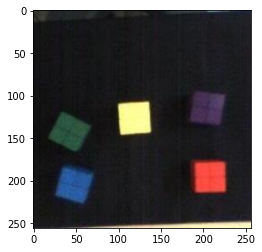

In [10]:
test_img_idx = 77
img_path = '/content/drive/MyDrive/Speech2Pickup/dataset1/train_img'
curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 1)

### Set test input script and Run the Result

In [11]:
curr_test_input = "pick up the left block the green one"
curr_embed_input, curr_seq_len = utils.load_test_script(curr_test_input, w2v_model, 
                                                        dim_sentence, max_step_sentence)    
mean_of_esti, uncertainty = session_run(result_heatmap, ph_image, ph_sen, 
                                         ph_sen_len, ph_dropout,
                                         restore_path = '/content/drive/MyDrive/Speech2Pickup/dataset1_model/Text2Pickup_model_wo/model.ckpt',
                                         curr_embed_input = curr_embed_input,
                                         curr_seq_len = curr_seq_len,
                                         curr_test_img = curr_test_img,
                                         dropout_rate=0.1)

Ready the test input script




INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/dataset1_model/Text2Pickup_model_wo/model.ckpt


### See the Result

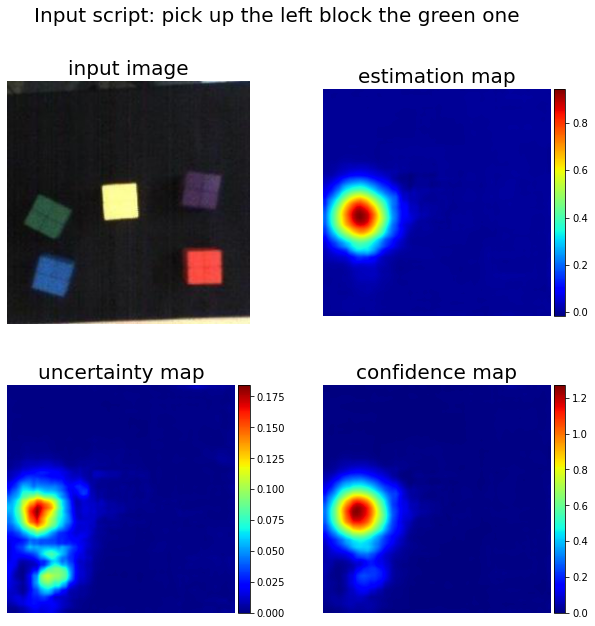

In [12]:
utils.plot_HGN_result(curr_test_input, curr_test_img, mean_of_esti, uncertainty, save_state=False, save_path='')

### Evaluate 'Text2Pickup' model : Model should be first defined

In [13]:
# Restore model

restore_path = '/content/drive/MyDrive/Speech2Pickup/dataset1_model/Text2Pickup_model_wo/model.ckpt'
init = tf.global_variables_initializer()
saver = tf.train.Saver()

config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True

T = 100

sess = tf.Session(config=config)
sess.run(init)
saver.restore(sess, restore_path)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/dataset1_model/Text2Pickup_model_wo/model.ckpt


In [15]:
# Evaluate model

import time

for i in range(5):
    img_path = '/content/drive/MyDrive/Speech2Pickup/dataset1/train_img'
    dropout_rate = 0.1
    num_test = len(idx_test)
    num_correct = 0
    correct_limit = 20 # 20 pixel (if the image size is 256x256)
    error_idx = []
    error = []

    taken_times = []

    for idx in idx_test:
        test_img_idx = img_idx[idx, :]
        curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 0)
        curr_embed_input = text_inputs[idx, :]
        curr_seq_len = seq_len[idx, :]
        curr_pos_outputs = pos_outputs[idx, :]

        start = time.time()
        
        test_feed_dict = {ph_sen: np.tile(curr_embed_input, (T, 1, 1)), 
                        ph_sen_len: np.tile(curr_seq_len, (T, 1)),
                        ph_image: np.tile(curr_test_img, (T, 1, 1, 1)),
                        ph_dropout: dropout_rate}
        test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

        test_heatmap = np.squeeze(test_heatmap)
        mean_of_esti = np.mean(test_heatmap, axis=0)
        
        mean_of_esti = resize(mean_of_esti, [256, 256], preserve_range=True)

        end = time.time()

        pose_esti = np.unravel_index(np.argmax(mean_of_esti), mean_of_esti.shape)
        pose_esti = np.flip(pose_esti)
        
        distance = np.sqrt(np.sum((pose_esti - curr_pos_outputs)**2))
        if distance < correct_limit:
            num_correct += 1
        else:
            error_idx.append(idx)
            error.append(distance)

        taken_time = end - start
        taken_times.append(taken_time)

    accuracy = (num_correct/num_test)*100
    print('Text2Pickup accuracy: {}%'.format(accuracy))

Text2Pickup accuracy: 98.39924670433146%
Text2Pickup accuracy: 98.58757062146893%
Text2Pickup accuracy: 98.58757062146893%
Text2Pickup accuracy: 98.49340866290018%
Text2Pickup accuracy: 98.49340866290018%


In [ ]:
taken_times_re = []

for i in taken_times:
    taken_times_re.append(i)
    taken_times_re.append(i)

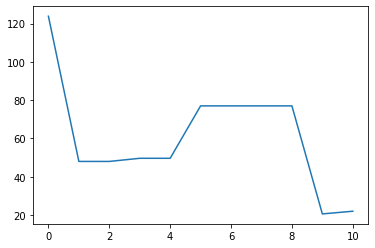

In [ ]:
# Plot error distance

import matplotlib.pyplot as plt

plt.plot(error)

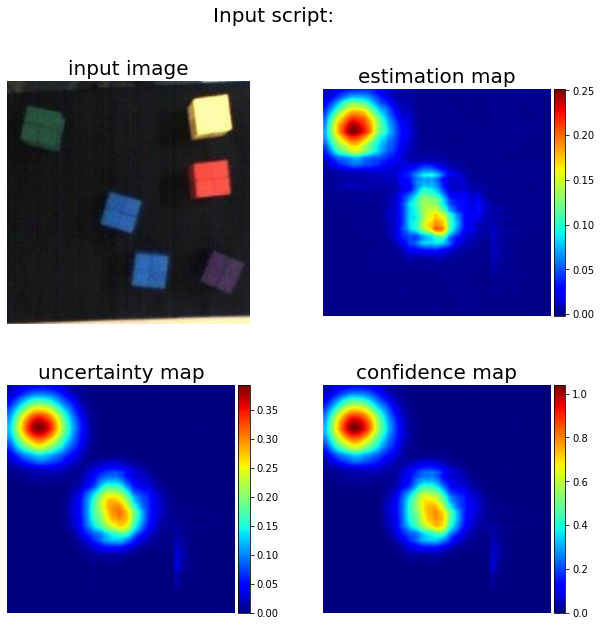

In [ ]:
# Plot one example of error case (maximum error)

idx = error_idx[np.argmax(error)]
test_img_idx = img_idx[idx, :]
curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 0)
curr_embed_input = text_inputs[idx, :]
curr_seq_len = seq_len[idx, :]
curr_pos_outputs = pos_outputs[idx, :]
curr_sentence = ''

test_feed_dict = {ph_sen: np.tile(curr_embed_input, (T, 1, 1)), 
                  ph_sen_len: np.tile(curr_seq_len, (T, 1)),
                  ph_image: np.tile(curr_test_img, (T, 1, 1, 1)),
                  ph_dropout: dropout_rate}
test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

test_heatmap = np.squeeze(test_heatmap)
mean_of_esti = np.mean(test_heatmap, axis=0)
mean_of_squared_esti = np.mean(test_heatmap**2, axis=0)
squared_mean_of_esti = mean_of_esti ** 2
uncertainty = np.sqrt(mean_of_squared_esti - squared_mean_of_esti)
utils.plot_HGN_result(curr_sentence, curr_test_img, mean_of_esti, uncertainty, save_state=False, save_path='')

### Evaluate 'ASR + Text2Pickup' model : Model should be first defined
### (Google Cloud Speech-To-Text API)

In [17]:
# Restore model

restore_path = '/content/drive/MyDrive/Speech2Pickup/dataset1_model/Text2Pickup_model_wo/model.ckpt'
init = tf.global_variables_initializer()
saver = tf.train.Saver()

config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True

T = 100

sess = tf.Session(config=config)
sess.run(init)
saver.restore(sess, restore_path)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/dataset1_model/Text2Pickup_model_wo/model.ckpt


In [18]:
# Load data

data = np.load('/content/drive/MyDrive/Speech2Pickup/dataset1/ASR_text2pickup_evaluate.npz')
img_idxs = data['img_idxs']
pos_outputs = data['pos_outputs']
real_text_inputs = data['real_text_inputs']
STT_text_inputs = data['STT_text_inputs']
num_STT_error = 0

for i in range(len(img_idxs)):
    if real_text_inputs[i] != STT_text_inputs[i]:
        num_STT_error += 1
print('STT accuracy: {}%'.format((1-(num_STT_error/len(img_idxs)))*100))

STT accuracy: 96.56308851224105%


In [21]:
# Evaluate model

import time
accuracys = []
for i in range(5):
    img_path = '/content/drive/MyDrive/Speech2Pickup/dataset1/train_img'
    dropout_rate = 0.1
    num_test = len(img_idxs)
    num_correct = 0
    num_STT_error_w_result_error = 0
    num_STT_error_w_result_correct = 0
    correct_limit = 20 # 20 pixel (if the image size is 256x256)
    error_idx = []
    error = []
    distances = []
    times = []

    for idx in range(num_test):
        print('Processing {}/{}'.format(idx+1, num_test))
        test_img_idx = img_idxs[idx]
        curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 0)
        real_text_input = real_text_inputs[idx]
        curr_text_input = STT_text_inputs[idx]
        curr_pos_outputs = pos_outputs[idx, :]

        curr_embed_input, curr_seq_len = utils.load_test_script(curr_text_input, w2v_model, 
                                                                dim_sentence, max_step_sentence)
        
        start = time.time()

        test_feed_dict = {ph_sen: np.tile(curr_embed_input, (T, 1, 1)), 
                        ph_sen_len: np.tile(curr_seq_len, (T, 1)),
                        ph_image: np.tile(curr_test_img, (T, 1, 1, 1)),
                        ph_dropout: dropout_rate}
        test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

        test_heatmap = np.squeeze(test_heatmap)
        mean_of_esti = np.mean(test_heatmap, axis=0)
        
        mean_of_esti = resize(mean_of_esti, [256, 256], preserve_range=True)

        end = time.time()

        pose_esti = np.unravel_index(np.argmax(mean_of_esti), mean_of_esti.shape)
        pose_esti = np.flip(pose_esti)
        
        distance = np.sqrt(np.sum((pose_esti - curr_pos_outputs)**2))
        if distance < correct_limit:
            num_correct += 1
            if real_text_input != curr_text_input:
                num_STT_error_w_result_correct += 1
        else:
            error_idx.append(idx)
            error.append(distance)
            if real_text_input != curr_text_input:
                num_STT_error_w_result_error += 1
        inter_time = end - start
        times.append(inter_time)

        distances.append(distance)

    accuracy = (num_correct/num_test)*100
    num_errors = num_test - num_correct
    print('ASR+Text2Pickup accuracy: {}%'.format(accuracy))
    accuracys.append(accuracy)
    # print('STT error contribution rate: {}%'.format((num_STT_error_w_result_error/num_errors)*100))
    # print('STT error ignored rate: {}%'.format((num_STT_error_w_result_correct/num_STT_error)*100))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Processing 1750/2124
Ready the test input script
Processing 1751/2124
Ready the test input script
Processing 1752/2124
Ready the test input script
Processing 1753/2124
Ready the test input script
Processing 1754/2124
Ready the test input script
Processing 1755/2124
Ready the test input script
Processing 1756/2124
Ready the test input script
Processing 1757/2124
Ready the test input script
Processing 1758/2124
Ready the test input script
Processing 1759/2124
Ready the test input script
Processing 1760/2124
Ready the test input script
Processing 1761/2124
Ready the test input script
Processing 1762/2124
Ready the test input script
Processing 1763/2124
Ready the test input script
Processing 1764/2124
Ready the test input script
Processing 1765/2124
Ready the test input script
Processing 1766/2124
Ready the test input script
Processing 1767/2124
Ready the test input script
Processing 1768/2124
Ready the test input script
Processing 1769/2124
Ready the te

In [23]:
accuracys = np.asarray(accuracys)
print(np.mean(accuracys))

98.06967984934086


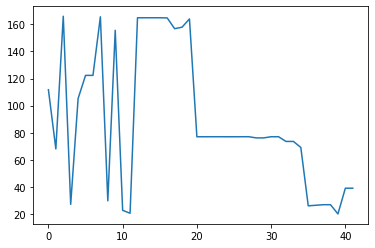

In [24]:
# Plot error distance

import matplotlib.pyplot as plt

plt.plot(error)

In [26]:
# Evaluate model inference time

times = np.asarray(times)
STT_compute_times = np.load('/content/drive/MyDrive/Speech2Pickup/dataset1/ASR_STT_time_evaluate.npz')['times']
taken_times_final = times + STT_compute_times

Q1 = np.percentile(taken_times_final, 25)
Q2 = np.percentile(taken_times_final, 50)
Q3 = np.percentile(taken_times_final, 75)
std = np.std(taken_times_final)
print('Q1: {}, Q2: {}, Q3: {}, std: {}'.format(Q1, Q2, Q3, std))

Q1: 1.0098261833190918, Q2: 1.2089701890945435, Q3: 1.2894310355186462, std: 0.2920191021377482


In [27]:
# Evaluate model inference error (distance)

print('mean: {}, std: {}'.format(np.mean(distances), np.std(distances)))

mean: 6.984316880939131, std: 13.967507202180895


In [28]:
# Evaluate model inference error (error)

print('mean: {}, std: {}'.format(np.mean(error), np.std(error)))

mean: 89.58845228673412, std: 50.67736113052136


### Evaluate 'ASR + Text2Pickup' model : Model should be first defined
### (DeepSpeech2)

In [29]:
# Restore model

restore_path = '/content/drive/MyDrive/Speech2Pickup/dataset1_model/Text2Pickup_model_wo/model.ckpt'
init = tf.global_variables_initializer()
saver = tf.train.Saver()

config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True

T = 100

sess = tf.Session(config=config)
sess.run(init)
saver.restore(sess, restore_path)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/dataset1_model/Text2Pickup_model_wo/model.ckpt


In [30]:
# Load data

data = np.load('/content/drive/MyDrive/Speech2Pickup/dataset1/ASR_deepspeech2_text2pickup_evaluate.npz')
img_idxs = data['img_idxs']
pos_outputs = data['pos_outputs']
real_text_inputs = data['real_text_inputs']
STT_text_inputs = data['STT_text_inputs']
num_STT_error = 0

for i in range(len(img_idxs)):
    if real_text_inputs[i] != STT_text_inputs[i]:
        num_STT_error += 1
print('STT accuracy: {}%'.format((1-(num_STT_error/len(img_idxs)))*100))

STT accuracy: 77.11864406779661%


In [32]:
# Evaluate model

accuracys = []

for i in range(5):
    img_path = '/content/drive/MyDrive/Speech2Pickup/dataset1/train_img'
    dropout_rate = 0.1
    num_test = len(img_idxs)
    num_correct = 0
    num_STT_error_w_result_error = 0
    num_STT_error_w_result_correct = 0
    correct_limit = 20 # 20 pixel (if the image size is 256x256)
    error_idx = []
    distances = []
    error = []
    times = []

    for idx in range(num_test):
        print('Processing {}/{}'.format(idx+1, num_test))
        test_img_idx = img_idxs[idx]
        curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 0)
        real_text_input = real_text_inputs[idx]
        curr_text_input = STT_text_inputs[idx]
        curr_pos_outputs = pos_outputs[idx, :]

        curr_embed_input, curr_seq_len = utils.load_test_script(curr_text_input, w2v_model, 
                                                                dim_sentence, max_step_sentence)
        
        start = time.time()

        test_feed_dict = {ph_sen: np.tile(curr_embed_input, (T, 1, 1)), 
                        ph_sen_len: np.tile(curr_seq_len, (T, 1)),
                        ph_image: np.tile(curr_test_img, (T, 1, 1, 1)),
                        ph_dropout: dropout_rate}
        test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

        test_heatmap = np.squeeze(test_heatmap)
        mean_of_esti = np.mean(test_heatmap, axis=0)
        
        mean_of_esti = resize(mean_of_esti, [256, 256], preserve_range=True)

        end = time.time()

        pose_esti = np.unravel_index(np.argmax(mean_of_esti), mean_of_esti.shape)
        pose_esti = np.flip(pose_esti)
        
        distance = np.sqrt(np.sum((pose_esti - curr_pos_outputs)**2))
        if distance < correct_limit:
            num_correct += 1
            if real_text_input != curr_text_input:
                num_STT_error_w_result_correct += 1
        else:
            error_idx.append(idx)
            error.append(distance)
            if real_text_input != curr_text_input:
                num_STT_error_w_result_error += 1
        inter_time = end - start
        times.append(inter_time)

        distances.append(distance)

    accuracy = (num_correct/num_test)*100
    num_errors = num_test - num_correct
    print('ASR+Text2Pickup accuracy: {}%'.format(accuracy))
    accuracys.append(accuracy)
    # print('STT error contribution rate: {}%'.format((num_STT_error_w_result_error/num_errors)*100))
    # print('STT error ignored rate: {}%'.format((num_STT_error_w_result_correct/num_STT_error)*100))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Processing 1750/2124
Ready the test input script
Processing 1751/2124
Ready the test input script
Processing 1752/2124
Ready the test input script
Processing 1753/2124
Ready the test input script
Processing 1754/2124
Ready the test input script
Processing 1755/2124
Ready the test input script
Processing 1756/2124
Ready the test input script
Processing 1757/2124
Ready the test input script
Processing 1758/2124
Ready the test input script
Processing 1759/2124
Ready the test input script
Processing 1760/2124
Ready the test input script
Processing 1761/2124
Ready the test input script
Processing 1762/2124
Ready the test input script
Processing 1763/2124
Ready the test input script
Processing 1764/2124
Ready the test input script
Processing 1765/2124
Ready the test input script
Processing 1766/2124
Ready the test input script
Processing 1767/2124
Ready the test input script
Processing 1768/2124
Ready the test input script
Processing 1769/2124
Ready the te

In [33]:
accuracys = np.asarray(accuracys)
print(np.mean(accuracys))

96.35593220338983


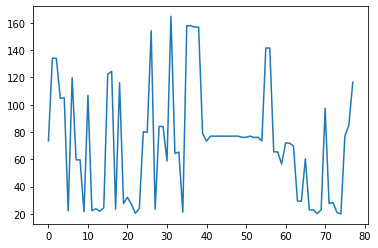

In [34]:
# Plot error distance

import matplotlib.pyplot as plt

plt.plot(error)

In [35]:
# Evaluate model inference time

times = np.asarray(times)
STT_compute_times = np.load('/content/drive/MyDrive/Speech2Pickup/dataset1/ASR_deepspeech2_STT_time_evaluate.npz')['times']
taken_times_final = times + STT_compute_times

Q1 = np.percentile(taken_times_final, 25)
Q2 = np.percentile(taken_times_final, 50)
Q3 = np.percentile(taken_times_final, 75)
std = np.std(taken_times_final)
print('Q1: {}, Q2: {}, Q3: {}, std: {}'.format(Q1, Q2, Q3, std))

Q1: 0.5439527034759521, Q2: 0.6028834581375122, Q3: 0.6721303462982178, std: 0.08581630025960213


In [36]:
# Evaluate model inference error (distance)

print('mean: {}, std: {}'.format(np.mean(distances), np.std(distances)))

mean: 7.933772756872427, std: 15.155306334942965


In [37]:
# Evaluate model inference error (error)

print('mean: {}, std: {}'.format(np.mean(error), np.std(error)))

mean: 72.46200210741527, std: 41.53005453972009
